In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

class TSR2_CNN:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape
        model = tf.keras.Sequential()

        # Convolution: Two layers with 32 filters of size 5x5, followed by ReLU activation and max pooling
        model.add(Conv2D(32, (5, 5), padding="same", activation="relu", input_shape=(height, width, depth)))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Convolution: Two layers with 64 filters of size 3x3, followed by ReLU activation and max pooling
        model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
        model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Convolution: One layer with 128 filters of size 3x3, followed by ReLU activation and max pooling
        model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Flatten the output to obtain a 1D vector
        model.add(Flatten())

        # Fully Connected: One layer with 512 neurons followed by ReLU activation
        model.add(Dense(512, activation="relu"))

        # Detection Layer: One fully connected layer with 256 neurons, ReLU activation,
        # and an output layer with 209 neurons and softmax activation
        model.add(Dense(256, activation="relu"))
        model.add(Dense(classes, activation="softmax"))

        return model


In [8]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [9]:
def load_split(basePath, csvPath):
    # initialize the list of data and labels
    data = []
    labels = []

    # load the contents of the CSV file, remove the first line (since
    # it contains the CSV header), and shuffle the rows (otherwise
    # all examples of a particular class will be in sequential order)
    rows = open(csvPath).read().strip().split("\n")[1:]
    random.shuffle(rows)

    # loop over the rows of the CSV file
    for (i, row) in enumerate(rows):
        # check to see if we should show a status update
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {} total images".format(i))

        # split the row into components and then grab the class ID
        # and image path
        (label, imagePath) = row.strip().split(",")[-2:]
        # derive the full path to the image file and load it
        imagePath = os.path.sep.join([basePath, imagePath])
        
        image = io.imread(imagePath)

        # resize the image to be 32x32 pixels, ignoring aspect ratio,
        # and then perform Contrast Limited Adaptive Histogram
        # Equalization (CLAHE)
        image = transform.resize(image, (32, 32))
        # image = exposure.equalize_adapthist(image, clip_limit=0.1)

        # update the list of data and labels, respectively
        data.append(image)
        labels.append(int(label))

    # convert the data and labels to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)

    # return a tuple of the data and labels
    return (data, labels)

In [10]:
# Danger signs
danger_signs = np.array([
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "Roundabout mandatory"
])

# Mandatory signs
mandatory_signs = np.array([
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No entry",
    "Roundabout mandatory",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory"
])

# Prohibitory signs
prohibitory_signs = np.array([
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Vehicles over 3.5 metric tons prohibited",
    "No vehicles",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
])


labelNames = np.array([
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
])

# NOTES : I need to add a "other" class to the dataset, this mean that I need to create images that are not in the dataset
# I want to create a model for each big class (prohibitory, mandatory, danger)
# If this doesn't work, I will try to add data that are from CARLA simulator


In [11]:
# Main path
main_path_EVO = os.path.sep.join(["images", "EVO"])
main_path_carla = os.path.sep.join(["images", "carla"])

# derive the path to the training and testing CSV files
test_carla = os.path.sep.join(["images", "carla", "labels.csv"])
trainPath = os.path.sep.join(["TS_data/", "Train.csv"])
testPath = os.path.sep.join(["TS_data/", "Test.csv"])
test_EVOPath = os.path.sep.join(["images/EVO/", "Test.csv"])

# load the training and testing data
print("[INFO] loading training and testing data...")
(test_X_carla, test_Y_carla) = load_split(main_path_carla, test_carla)
(testX, testY) = load_split("TS_data", testPath)
(trainX, trainY) = load_split("TS_data", trainPath)
(test_EVO_X, test_EVO_Y) = load_split(main_path_EVO, test_EVOPath)

# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
test_EVO_X = test_EVO_X.astype("float32") / 255.0
test_X_carla = test_X_carla.astype("float32") / 255.0

# one-hot encode the training and testing labels
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)
test_EVO_Y = to_categorical(test_EVO_Y, numLabels)
test_X_carla = test_X_carla[test_Y_carla != 43]
test_Y_carla = test_Y_carla[test_Y_carla != 43]
test_Y_carla = to_categorical(test_Y_carla, numLabels)

# calculate the total number of images in each class and
# initialize a dictionary to store the class weights
classTotals = trainY.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

[INFO] loading training and testing data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[I

In [12]:
# Split the training data into training and validation data
from sklearn.model_selection import train_test_split

trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=0)

print(trainX.shape, trainY.shape)
print(valX.shape, valY.shape)
print(testX.shape, testY.shape)
print(test_X_carla.shape, test_Y_carla.shape)

(31367, 32, 32, 3) (31367, 43)
(7842, 32, 32, 3) (7842, 43)
(12630, 32, 32, 3) (12630, 43)
(311, 32, 32, 3) (311, 43)


In [26]:
NUM_EPOCHS = 100
INIT_LR = 0.01
BS = 64
decay_steps = int(trainX.shape[0] // BS)
decay_rate = 0.5

490


In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# Define a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=tf.cast(decay_steps, tf.int32),
    decay_rate=decay_rate)

# lr_schedule = INIT_LR

opt = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)

# initialize the optimizer and compile the model
print("[INFO] compiling model...")

model = TSR2_CNN.build(width=32, height=32, depth=3, classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(valX, valY),
    steps_per_epoch=trainX.shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    verbose=1)

accuracy 0.007890617474913597
validation accuracy 0.006630961317569017
loss 9.266905784606934
validation loss 3.7604684829711914
981/981 [==============================] - 17s 18ms/step
f1_score 0.0003648547752943296
246/246 [==============================] - 4s 17ms/step
validation f1_score 0.000306385185097896


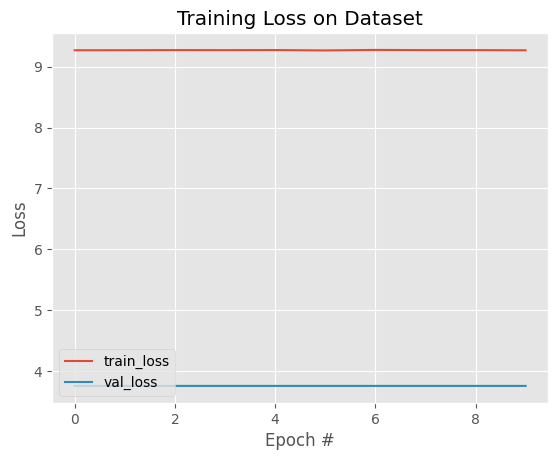

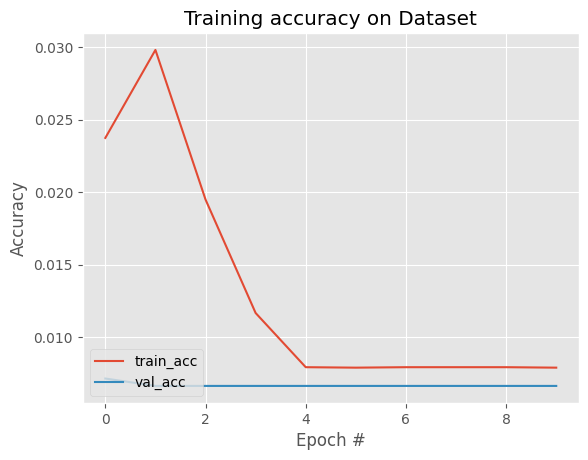

In [13]:
import os

if not os.path.exists("plots"):
    os.makedirs("plots")


# plot the 'training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('plots/TSR2_loss__e' + str(NUM_EPOCHS) + '_decay0_' + str(decay_rate).split('.')[1] + '_lr0_' + str(INIT_LR).split('.')[1] + '_bs' + str(BS))

plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig('plots/TSR2_accuracy_e' + str(NUM_EPOCHS) + '_decay0_' + str(decay_rate).split('.')[1] + '_lr0_' + str(INIT_LR).split('.')[1] + '_bs' + str(BS))

# Plot last accuracy and loss
print("accuracy", H.history["accuracy"][-1])
print("validation accuracy", H.history["val_accuracy"][-1])
print("loss", H.history["loss"][-1])
print("validation loss", H.history["val_loss"][-1])

# F1 score
from sklearn.metrics import f1_score
print("f1_score", f1_score(trainY.argmax(axis=1), model.predict(trainX).argmax(axis=1), average='macro'))
print("validation f1_score", f1_score(valY.argmax(axis=1), model.predict(valX).argmax(axis=1), average='macro'))

In [ ]:
# plot accuracy and loss lists
plt.style.use("ggplot")
plt.figure()
plt.plot(accuracy_list, label="train_acc")
plt.plot(val_accuracy_list, label="val_acc")
plt.title("Training accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy") 

plt.style.use("ggplot")
plt.figure()
plt.plot(loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")
plt.title("Training accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss") 

# plot f1 score lists
plt.style.use("ggplot")
plt.figure()
plt.plot(f1_score_list, label="train_f1_score")
plt.plot(val_f1_score_list, label="val_f1_score")
plt.plot(test_f1_score_list, label="test_f1_score")
plt.title("f1_score on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("f1_score")

In [45]:
# Save your model
model.save('model_trafficSignNet/model_TrafficSignNet.h5', save_format='h5')

In [ ]:
from keras.models import load_model

# Load the saved model
# model = load_model('model_trafficSignNet/best_model.h5')
model = load_model('model_trafficSignNet/model_TrafficSignNet.h5')

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_X_carla, batch_size=BS)
print(classification_report(test_Y_carla.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames, labels=np.arange(0, 43)))

# F1 score
from sklearn.metrics import f1_score
print("test f1 score", f1_score(testY.argmax(axis=1), model.predict(testX).argmax(axis=1), average='macro'))
print("f1_score", f1_score(test_EVO_Y.argmax(axis=1), model.predict(test_EVO_X).argmax(axis=1), average='macro'))

In [51]:
from imutils import paths


# load the traffic sign recognizer model
print("[INFO] loading model...")
# model = load_model("model_trafficSignNet/best_model.h5")

# grab the paths to the input images, shuffle them, and grab a sample
print("[INFO] predicting...")
# imagePaths = list(paths.list_images("images\EVO\\Test"))
# random.shuffle(imagePaths)
# imagePaths = imagePaths[:]

# loop over csv file
# open csv file
csvPath = os.path.sep.join(["images\carla", "labels.csv"])
rows = open(csvPath).read().strip().split("\n")[1:]

# initialize the list of data and labels
imagePaths = []
labelsImage = []
for row in rows:
    (label, imagePath) = row.strip().split(",")[-2:]
    imagePath = os.path.sep.join(["images/carla", imagePath])
    imagePaths.append(imagePath)
    labelsImage.append(label)

imagePaths = imagePaths[:1]

# random.shuffle(imagePaths)
# random.shuffle(labelsImage)

[INFO] loading model...
[INFO] predicting...


In [55]:
import imutils
import cv2

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# load the image, resize it to 32x32 pixels, and then apply
	# Contrast Limited Adaptive Histogram Equalization (CLAHE),
	# just like we did during training
	image = io.imread(imagePath)
	image = transform.resize(image, (32, 32))
	# image = exposure.equalize_adapthist(image, clip_limit=0.1)
	# preprocess the image by scaling it to the range [0, 1]
	image = image.astype("float32") / 255.0
	image = np.expand_dims(image, axis=0)
	# make predictions using the traffic sign recognizer CNN
	preds = model.predict(image)
	j = preds.argmax(axis=1)[0]
	label = labelNames[j]
	# load the image using OpenCV, resize it, and draw the label
	# on it
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=128)
	cv2.putText(image, label, (5, 15), cv2.FONT_HERSHEY_SIMPLEX,
		0.45, (0, 0, 255), 2)
	# save the image to disk
	p = os.path.sep.join(["images/carla/", "{}.png".format(i)])
	cv2.imwrite(p, image)
	print("[INFO] predicted: {}".format(labelNames[j]), ", ground truth: {}".format(labelsImage[i]))

1/1 [==============================] - 0s 23ms/step
[INFO] predicted: Speed limit (70km/h) , ground truth: 3
